In [13]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import math
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from image_pipeline import Operation, Color, Sobel, Magnitude, Direction, \
  Threshold, Combinator, FindLinesSlidingWindows, Annotate, ImagePipeline
    
import pickle

In [14]:
ip = ImagePipeline(input_color='bgr')
with open( "../calibration-elp-final/cal-elp.p", "rb" ) as pfile:
    cal = pickle.load(pfile)
mtx = cal['mtx']
dist = cal['dist']

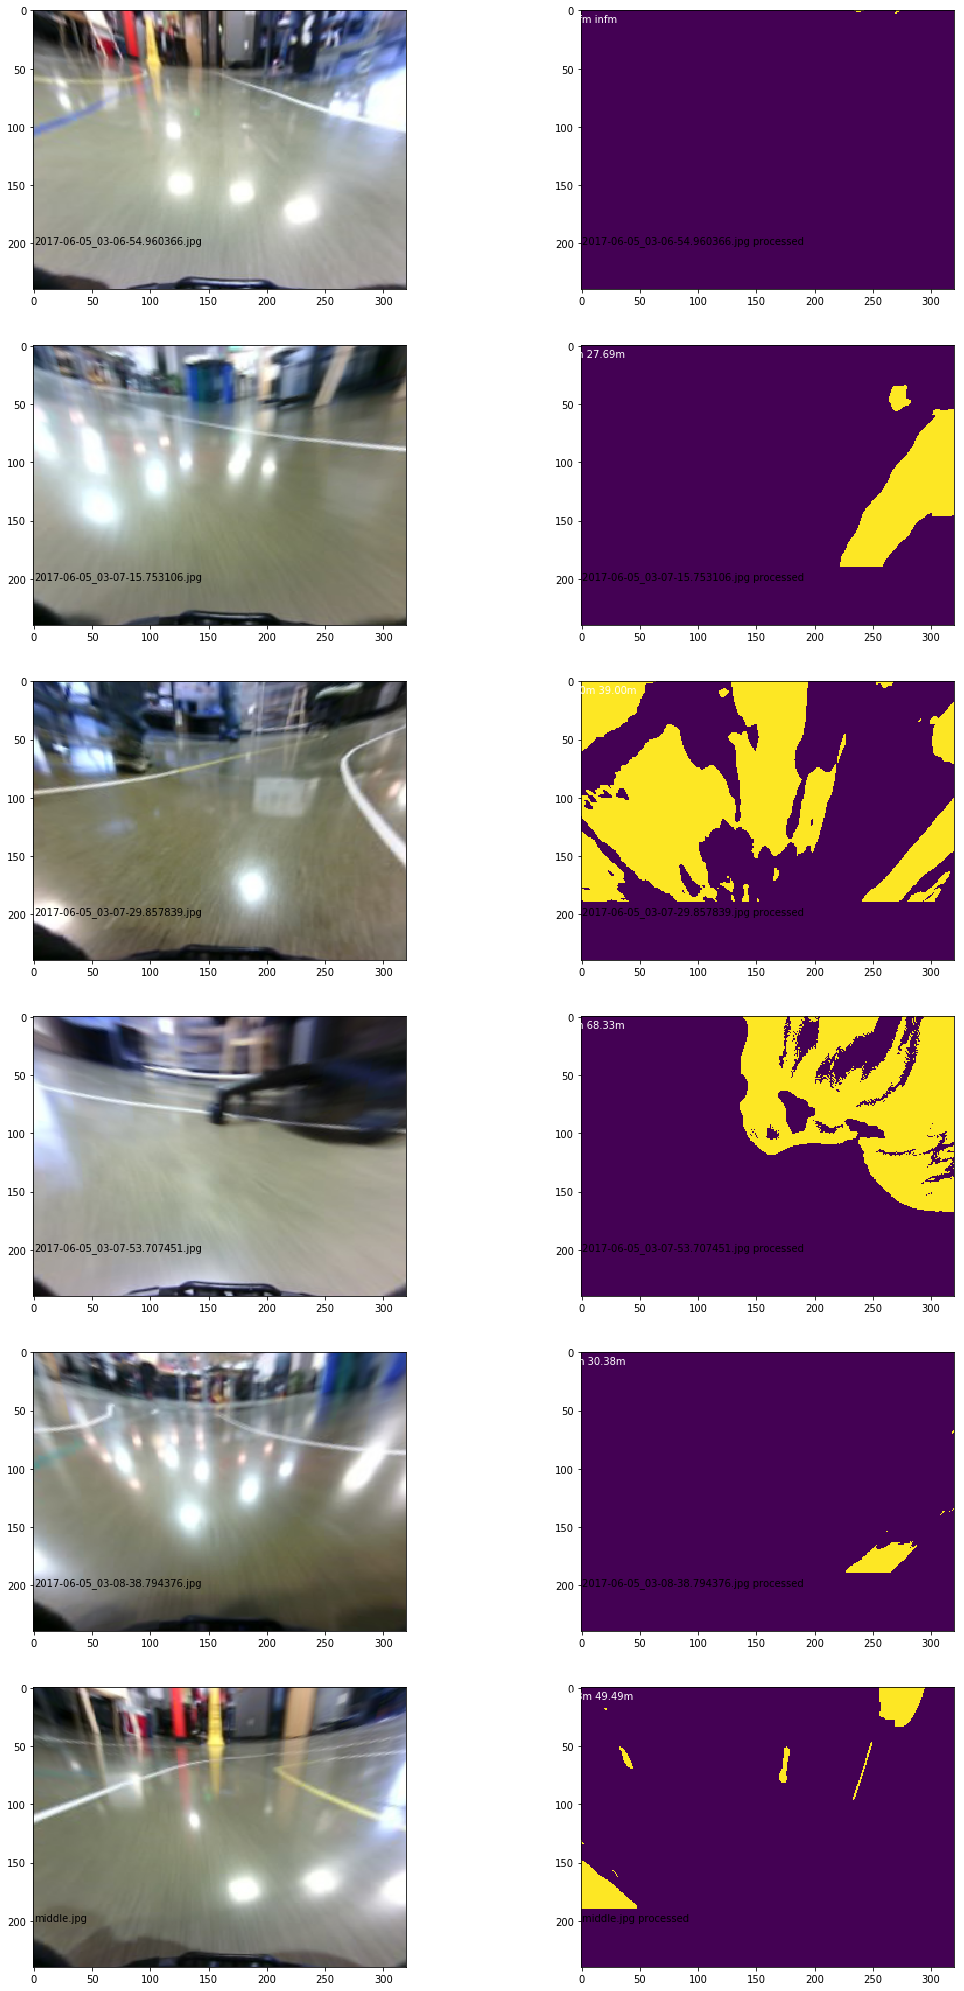

In [17]:
def adjust_thresholds(change=None):
    """
    combiner values: "dir", "mag", None
    """
    r=r_i.value
    g=g_i.value
    b=b_i.value
    h=h_i.value
    l=l_i.value
    s=s_i.value
    y=y_i.value
    u=u_i.value
    v=v_i.value
    h2=h2_i.value
    s2=s2_i.value
    v2=v2_i.value
    sobel_x=sobel_x_i.value
    sobel_y=sobel_y_i.value
    sobel_x_kernel=sobel_y_i.value
    sobel_y_kernel=sobel_y_kernel_i.value
    combiner=combiner_i.value
    mag_or_sobel_range=mag_or_sobel_range_i.value
    dir_range=dir_range_i.value
    inrange_min1 = inrange_min1_i.value
    inrange_min2 = inrange_min2_i.value
    inrange_min3 = inrange_min3_i.value
    inrange_max1 = inrange_max1_i.value
    inrange_max2 = inrange_max2_i.value
    inrange_max3 = inrange_max3_i.value
    
    ip = ImagePipeline(input_color='bgr')
    # ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
    ip.mtx = mtx
    ip.dist = dist

    img_size = (320, 240)

    left_top = 120
    left_bottom = 0
    right_top = 200
    right_bottom = 320
    top = 75
    bottom = 175


    src = np.float32([[left_bottom,bottom],
                     [left_top,top],
                     [right_top,top],
                     [right_bottom,bottom]])

    width = 220
    left = (img_size[0] - width) / 2
    right = left + width
    top = 0
    bottom = 240
    dst = np.float32([[left,bottom],
                     [left,top],
                     [right,top],
                     [right,bottom]])

    ip.set_perspective(src, dst)
            
    if combiner == 'dir':
        t = Threshold(trange=dir_range, crop_b=50)
    else:
        t = Threshold(trange=mag_or_sobel_range, crop_b=50)
        
    cc = []
    if r:
        cc.append('r')
    if g:
        cc.append('g')
    if b:
        cc.append('b')
    if h:
        cc.append('h')
    if l:
        cc.append('l')
    if s:
        cc.append('s')
    if y:
        cc.append('y')
    if u:
        cc.append('u')
    if v:
        cc.append('v')
    if h2:
        cc.append('h2')
    if s2:
        cc.append('s2')
    if v2:
        cc.append('v2')
    if len(cc) == 3:
        t.add(Color(cc, in_range=((inrange_min1, inrange_min2, inrange_min3),
                                  (inrange_max1, inrange_max2, inrange_max3))))

        if sobel_x:
            t.add(Sobel('x', kernel=sobel_x_kernel))

        if sobel_y:
            t.add(Sobel('y', kernel=sobel_y_kernel))

        if combiner == 'dir':
            t.add(Direction())
        elif combiner == 'mag':
            t.add(Magnitude())

        ip.add(t)
        c = Combinator(f=(lambda ths: np.where((ths[0] >= 1))))
        ip.add(c)
        f = FindLinesSlidingWindows(always_recalculate=True)
        ip.add(f)

#         a = Annotate(f, 20, 20)
#         ip.add(a)

        all_images = glob.glob('test_images/*.jpg')
        img_paths = all_images[:]
#         img_paths = ['test_images/test9.jpg', 'test_images/test8.jpg', 'test_images/test_from_course.jpg', 'test_images/test7.jpg', 'test_images/test4.jpg']

        cols = 2
        rows = math.ceil(float(len(img_paths))/cols)*2
        fig = plt.figure(figsize=(18, 6*rows))
        i = 0
        for fname in img_paths:
            ax = fig.add_subplot(rows, cols, i+1)
            name = os.path.basename(fname)
            img = cv2.imread(fname)
#             img = cv2.resize(img, (1280, 720))
            processed = ip.process(img)

            plt.imshow(ip.undist_img)
            plt.text(0, 200, name)
            i+=1

            ax = fig.add_subplot(rows, cols, i+1)
            plt.imshow(processed)

            plt.text(0, 200, "{} processed".format(name))
            plt.text(10, 10, "{:.2f}m {:.2f}m".format(f.left_curverad_m, f.right_curverad_m), color='white', ha='center')
            i+=1
        clear_output(True)
    else:
        clear_output(True)
        print("Choose three colors")


r_i = Checkbox(description='r', value=False)
g_i = Checkbox(description='g', value=False)
b_i = Checkbox(description='b', value=False)
h_i = Checkbox(description='h', value=False )
l_i = Checkbox(description='l', value=False)
s_i = Checkbox(description='s', value=False)
y_i = Checkbox(description='y', value=False)
u_i = Checkbox(description='u', value=False)
v_i = Checkbox(description='v', value=False)
h2_i = Checkbox(description='h2', value=True)
s2_i = Checkbox(description='s2', value=True)
v2_i = Checkbox(description='v2', value=True)
inrange_min1_i = IntSlider(description='inrange min 1', min=0, max=255, step=1, value=20)
inrange_min2_i = IntSlider(description='inrange min 2', min=0, max=255, step=1, value=100)
inrange_min3_i = IntSlider(description='inrange min 3', min=0, max=255, step=1, value=12)
inrange_max1_i = IntSlider(description='inrange max 1', min=1, max=255, step=1, value=138)
inrange_max2_i = IntSlider(description='inrange max 2', min=1, max=255, step=1, value=255)
inrange_max3_i = IntSlider(description='inrange max 3', min=1, max=255, step=1, value=255)
sobel_x_i = Checkbox(description='sobel x', value=False)
sobel_y_i = Checkbox(description='sobel y', value=False)
sobel_x_kernel_i = IntSlider(description='sobel x kernel', min=1, max=31, step=2, value=3)
sobel_y_kernel_i = IntSlider(description='sobel y kernel', min=1, max=31, step=2, value=3)
combiner_i = RadioButtons(description='combiner', options=[None, 'mag', 'dir'], value=None)
mag_or_sobel_range_i = IntRangeSlider(description='color, mag, or sobel range', min=0, max=512, step=1, value=[1, 255])
dir_range_i = FloatRangeSlider(description='dir range', min=0, max=np.pi / 2, step=0.01,value=[0.7, 1.3])

r_i.observe(adjust_thresholds, 'value')
g_i.observe(adjust_thresholds, 'value')
b_i.observe(adjust_thresholds, 'value')
h_i.observe(adjust_thresholds, 'value')
l_i.observe(adjust_thresholds, 'value')
s_i.observe(adjust_thresholds, 'value')
y_i.observe(adjust_thresholds, 'value')
u_i.observe(adjust_thresholds, 'value')
v_i.observe(adjust_thresholds, 'value')
h2_i.observe(adjust_thresholds, 'value')
s2_i.observe(adjust_thresholds, 'value')
v2_i.observe(adjust_thresholds, 'value')
inrange_min1_i.observe(adjust_thresholds, 'value')
inrange_min2_i.observe(adjust_thresholds, 'value')
inrange_min3_i.observe(adjust_thresholds, 'value')
inrange_max1_i.observe(adjust_thresholds, 'value')
inrange_max2_i.observe(adjust_thresholds, 'value')
inrange_max3_i.observe(adjust_thresholds, 'value')
sobel_x_i.observe(adjust_thresholds, 'value')
sobel_y_i.observe(adjust_thresholds, 'value')
sobel_x_kernel_i.observe(adjust_thresholds, 'value')
sobel_y_kernel_i.observe(adjust_thresholds, 'value')
combiner_i.observe(adjust_thresholds, 'value')
mag_or_sobel_range_i.observe(adjust_thresholds, 'value')
dir_range_i.observe(adjust_thresholds, 'value')

display(r_i, g_i, b_i, h_i, l_i, s_i, y_i, u_i, v_i, h2_i, s2_i, v2_i,
        inrange_min1_i, inrange_min2_i, inrange_min3_i,
        inrange_max1_i, inrange_max2_i, inrange_max3_i)
adjust_thresholds()

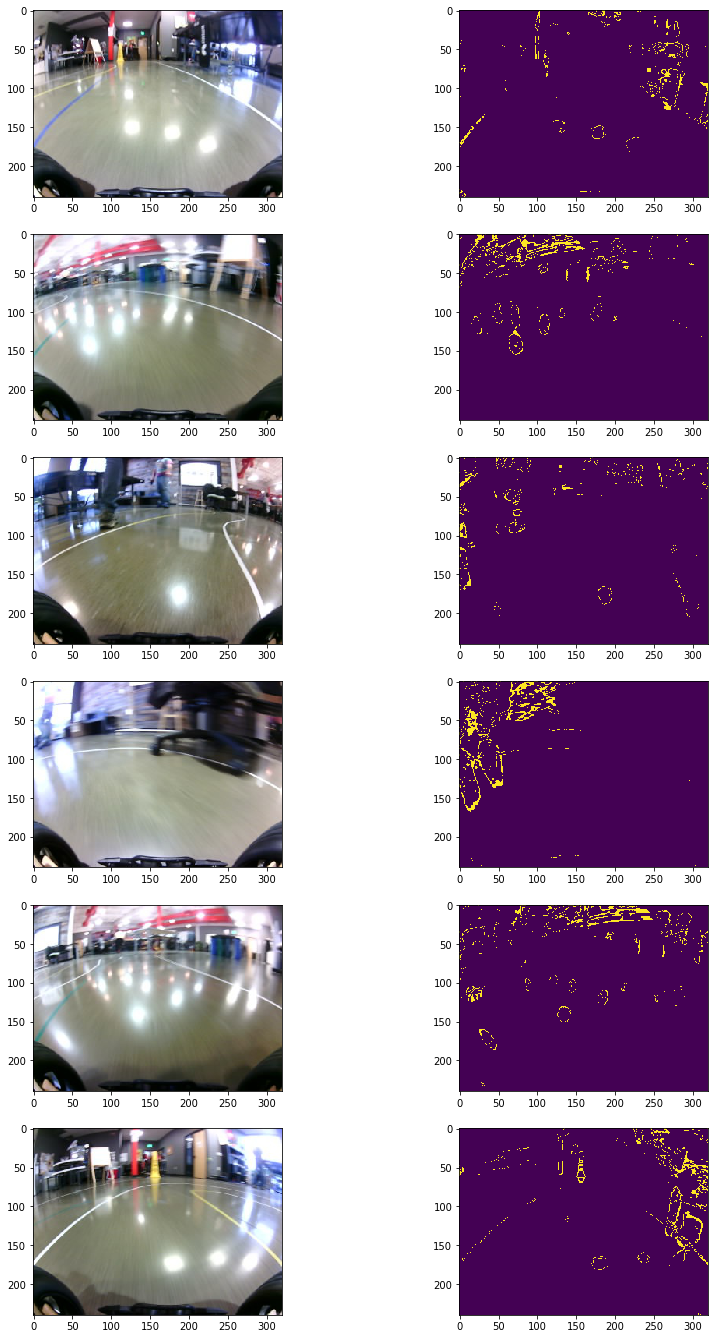

In [19]:
def find_color_hsv(change=None):
    inrange_min1 = inrange_min1_i.value
    inrange_min2 = inrange_min2_i.value
    inrange_min3 = inrange_min3_i.value
    inrange_max1 = inrange_max1_i.value
    inrange_max2 = inrange_max2_i.value
    inrange_max3 = inrange_max3_i.value
    
#     img_paths = ['test_images/test9.jpg', 'test_images/test8.jpg', 'test_images/test_from_course.jpg', 'test_images/test7.jpg', 'test_images/test4.jpg']
#     img_paths = ['test_images/test11.jpg', 'test_images/test12.jpg']
    img_paths = glob.glob('test_images/*.jpg')
    fig = plt.figure(figsize=(14, len(img_paths)*4))
    rows = len(img_paths)
    cols = 2
    i = 1

    for img_path in img_paths:
        ax = fig.add_subplot(rows, cols, i)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        i += 1

        ax = fig.add_subplot(rows, cols, i)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img = cv2.inRange(img, (inrange_min1, inrange_min2, inrange_min3), (inrange_max1, inrange_max2, inrange_max3))
        plt.imshow(img)
        i += 1

    clear_output(True)

inrange_min1_i = IntSlider(description='inrange min 1', min=0, max=255, step=1, value=20)
inrange_min2_i = IntSlider(description='inrange min 2', min=0, max=255, step=1, value=100)
inrange_min3_i = IntSlider(description='inrange min 3', min=0, max=255, step=1, value=12)
inrange_max1_i = IntSlider(description='inrange max 1', min=1, max=255, step=1, value=138)
inrange_max2_i = IntSlider(description='inrange max 2', min=1, max=255, step=1, value=255)
inrange_max3_i = IntSlider(description='inrange max 3', min=1, max=255, step=1, value=255)

inrange_min1_i.observe(find_color_hls, 'value')
inrange_min2_i.observe(find_color_hls, 'value')
inrange_min3_i.observe(find_color_hls, 'value')
inrange_max1_i.observe(find_color_hls, 'value')
inrange_max2_i.observe(find_color_hls, 'value')
inrange_max3_i.observe(find_color_hls, 'value')

display(inrange_min1_i, inrange_min2_i, inrange_min3_i,
        inrange_max1_i, inrange_max2_i, inrange_max3_i)
find_color_hsv()